In [ ]:
from sklearn.datasets import load_iris
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [ ]:
iris = load_iris()
dir(iris)

['DESCR',
 'data',
 'data_module',
 'feature_names',
 'filename',
 'frame',
 'target',
 'target_names']

In [ ]:
data = iris.data[:, [2,3]]
labels = iris.target
feature_names = iris.feature_names[:2]

In [ ]:
df = pd.DataFrame(data, columns= feature_names)
df['Type'] = iris.target_names[labels]
df

,sepal length (cm),sepal width (cm),Type
0,1.4,0.2,setosa
1,1.4,0.2,setosa
2,1.3,0.2,setosa
3,1.5,0.2,setosa
4,1.4,0.2,setosa
...,...,...,...
145,5.2,2.3,virginica
146,5.0,1.9,virginica
147,5.2,2.0,virginica
148,5.4,2.3,virginica


In [ ]:
# Preprocessing
from sklearn.preprocessing import StandardScaler

st = StandardScaler()
x_data = st.fit_transform(data)[:]
y_data = labels[:]

print(f"""
      Training Size: {x_data.shape}
""")


      Training Size: (150, 2)



In [ ]:
import tensorflow as tf

In [ ]:
# TO tensor
x_vals = tf.constant(x_data, dtype= tf.float32)
y_vals = tf.constant(y_data, dtype= tf.float32)

In [ ]:
class NNetwork:
  """
    Optimezers:
                - momentum. SGD with momentum
                - sgd. SGD

    Activation Function:
                - Sigmoid
                - ReLu
  """
  def __init__(self, input_dim, output_dim, units, beta= 0.9, optimizer= 'momentum', activation= 'relu'):
    self.weights0 =  tf.Variable(tf.random.normal((units, input_dim), mean= 0., stddev= 0.1, dtype= tf.float32)) - 0.2
    self.weights1 =  tf.Variable(tf.random.normal((output_dim, units), mean= 0., stddev= 0.1, dtype= tf.float32)) - 0.2
    self.bias0 = tf.Variable(tf.zeros((units, 1), dtype= tf.float32))
    self.bias1 = tf.Variable(tf.zeros((output_dim, 1), dtype= tf.float32))
    self.k = output_dim
    self.v_dw0 = tf.Variable(tf.zeros(self.weights0.shape))
    self.v_db0 = tf.Variable(tf.zeros(self.bias0.shape))
    self.v_dw1 = tf.Variable(tf.zeros(self.weights1.shape))
    self.v_db1 = tf.Variable(tf.zeros(self.bias1.shape))
    self.beta = beta
    self.optimizer= optimizer
    self.activation = activation

  def one_hot(self, y):
    m = len(y)
    labels = np.zeros(shape= (m, self.k))
    labels[np.arange(0,m,1), y.numpy().astype(int)] = 1
    return tf.cast(tf.transpose(labels), dtype= tf.float32)

  def softmax(self, Z):
    max_per_row = tf.reduce_max(Z, axis= 1, keepdims= True)
    Z_norm = Z - max_per_row
    Z_norm = tf.exp(tf.transpose(Z_norm))
    A = Z_norm / np.sum(Z_norm, axis = 1, keepdims = True)
    return tf.transpose(A)

  def sigmoid(self, X):
    return tf.nn.sigmoid(X)

  def sigmoid_prime(self, A):
    return A * (1 - A)

  def ReLu(self, X):
    return tf.clip_by_value(X, 0.0, float('inf'))

  def ReLu_prime(self, X):
    return tf.cast(X > 0.0, dtype= tf.float32)

  def feedforward(self, X):
    X_t = tf.transpose(X)
    Z0 = self.weights0 @ X_t + self.bias0
    if self.activation == 'sigmoid':
      A0 = self.sigmoid(Z0)
    elif self.activation == 'relu':
      A0 = self.ReLu(Z0)
    Z1 = self.weights1 @ A0 + self.bias1
    A1 = self.softmax(Z1)
    return A0, A1

  def backpropagation(self, X, y, A0, A1):
    y_enc = self.one_hot(y)

    m = len(X)
    A1_n = tf.clip_by_value(A1, -float('inf'), 0)

    dz1 = A1_n - y_enc
    dw1 = dz1 @ tf.transpose(A0) * 1 / m
    db1 = tf.expand_dims(np.sum(dz1, axis= 1), 1) * 1 / m

    activation = self.sigmoid_prime(A0) if self.activation == 'sigmoid' else self.ReLu_prime(A0)
    dz0 = tf.transpose(self.weights1) @ dz1 * activation
    dw0 = dz0 @ X * 1 / m
    db0 = tf.expand_dims(np.sum(dz0, axis= 1), 1) * 1 / m

    # Momentum
    self.v_dw0 = self.v_dw0 * self.beta + self.eta * dw0
    self.v_db0 = self.v_db0 * self.beta + self.eta * db0
    self.v_dw1 = self.v_dw1 * self.beta + self.eta * dw1
    self.v_db1 = self.v_db1 * self.beta + self.eta * db1

    return dw0, db0, dw1, db1

  def cross_entropy(self, y_true, y_pred):
    y_enc = self.one_hot(y_true)
    eps = 1e-10
    return -tf.reduce_mean(tf.reduce_sum(y_enc * tf.math.log(y_pred + eps), axis= 0))

  def update_params(self, dw0,db0,dw1,db1):
    if self.optimizer == 'sgd':
      self.weights0 = self.weights0 - self.eta * dw0
      self.bias0 = self.bias0 - self.eta * db0
      self.weights1 = self.weights1 - self.eta * dw1
      self.bias1 = self.bias1 - self.eta * db1
    elif self.optimizer == 'momentum' :
      self.weights0 = self.weights0 - self.v_dw0
      self.bias0 = self.bias0 - self.v_db0
      self.weights1 = self.weights1 - self.v_dw1
      self.bias1 = self.bias1 - self.v_db1


  def score(self, X, y):
    _, prediction = self.feedforward(X)
    A = np.argmax(prediction, axis= 0)
    return tf.reduce_mean(tf.cast(tf.equal(A, y), dtype= tf.float32))

  def predict(self, X):
    _, prediction = self.feedforward(X)
    return np.argmax(prediction, axis= 0)

  def fit(self, X, y, epochs = 10, learning_rate = 0.01, batch_size = 33):
    self.eta = learning_rate

    for ite in range(1, epochs+1):
      perm = np.random.permutation(len(X))

      for batch in range(0, len(X)- batch_size, batch_size):
        x_rand = tf.gather(X, np.array(range(batch, batch+batch_size)))
        y_rand = tf.gather(y, np.array(range(batch, batch+batch_size)))

        # Feedforward
        A0,A1 = self.feedforward(x_rand)
        # Backpropagation
        dw0,db0,dw1,db1 = self.backpropagation(x_rand, y_rand, A0, A1)
        # Update Parameters
        self.update_params(dw0,db0,dw1,db1)

      if ite % 5 == 0:
        score = self.score(X, y)
        _, X_pred = self.feedforward(X)
        loss = self.cross_entropy(y, X_pred)
        print(f'Iteration: {ite} -- Score: {score} -- Loss: {loss}')

In [ ]:
clf = NNetwork(input_dim= 2, output_dim= 3, units= 1000, optimizer= 'momentum', beta= 0.95, activation= 'relu')
clf.fit(x_vals, y_vals, epochs = 50, learning_rate = 0.001, batch_size = 25)

Iteration: 5 -- Score: 0.6399999856948853 -- Loss: 0.8765732645988464
Iteration: 10 -- Score: 0.7133333086967468 -- Loss: 0.710951030254364
Iteration: 15 -- Score: 0.8600000143051147 -- Loss: 0.43745747208595276
Iteration: 20 -- Score: 0.800000011920929 -- Loss: 0.426339715719223
Iteration: 25 -- Score: 0.7133333086967468 -- Loss: 0.4132467210292816
Iteration: 30 -- Score: 0.6666666865348816 -- Loss: 0.7333757281303406
Iteration: 35 -- Score: 0.6666666865348816 -- Loss: nan
Iteration: 40 -- Score: 0.6666666865348816 -- Loss: nan
Iteration: 45 -- Score: 0.8799999952316284 -- Loss: nan
Iteration: 50 -- Score: 0.8733333349227905 -- Loss: nan


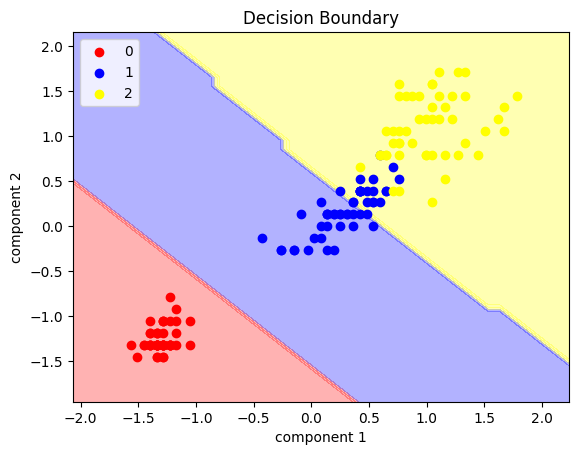

In [ ]:
# Visualize Decision Boundary

x_set, y_set = x_data, y_data
colors = ['red', 'blue', 'yellow']

X1, X2 = np.meshgrid(np.arange(min(x_set[:,0])-0.5, max(x_set[:,0])+0.5, 0.1),
                    np.arange(min(x_set[:,1])-0.5, max(x_set[:,1])+0.5, 0.1))
a = tf.constant(np.c_[X1.ravel(), X2.ravel()], dtype= tf.float32)

Z = clf.predict(a).reshape(X1.shape)

plt.contourf(X1, X2, Z, alpha= 0.3, cmap= ListedColormap(('red','blue','yellow')))
for i, label in enumerate(np.unique(y_set)):
    plt.scatter(x= x_set[label == y_set, 0], y= x_set[label == y_set, 1],
                label= label, color= colors[i])

plt.title('Decision Boundary')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.legend()
plt.show()